![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# Подготовка
## 1. import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max.columns', 100)

import re # for strings processing
import json
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file = os.path.join(dirname, filename)
        print(file)
        os_files.append(file)

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/tripadviso-parsing/UNdata_Export_new.csv
/kaggle/input/tripadviso-parsing/country_data.json
/kaggle/input/tripadviso-parsing/currency_rates.json
/kaggle/input/tripadviso-parsing/data_scraping.py
/kaggle/input/tripadviso-parsing/parsed_data_output3.csv
/kaggle/input/tripadviso-parsing/UNdata_Export.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## 2. Подгружаем внешние данные

In [4]:
# скрипт с загрузкой внешних данных - см draft.py на github

DATA_DIR = '/kaggle/input/'
countries_info = pd.read_json(DATA_DIR+'tripadviso-parsing/country_data.json', orient='records')
display(countries_info.sample(3))

# no Italy in this dataset
cities_info = pd.read_csv(DATA_DIR+'tripadviso-parsing/UNdata_Export_new.csv')
display(cities_info.sample(3))

with open(DATA_DIR+'tripadviso-parsing/currency_rates.json', 'r') as file:
    currency_rates = json.load(file)

pprint(currency_rates)

,name,topLevelDomain,alpha2Code,alpha3Code,callingCodes,capital,altSpellings,region,subregion,population,latlng,demonym,area,gini,timezones,borders,nativeName,numericCode,currencies,languages,translations,flag,regionalBlocs,cioc
51,Ukraine,[.ua],UA,UKR,[380],Kiev,"[UA, Ukrayina]",Europe,Eastern Europe,42692393,"[49.0, 32.0]",Ukrainian,603700.0,26.4,[UTC+02:00],"[BLR, HUN, MDA, POL, ROU, RUS, SVK]",Україна,804.0,"[{'code': 'UAH', 'name': 'Ukrainian hryvnia', ...","[{'iso639_1': 'uk', 'iso639_2': 'ukr', 'name':...","{'de': 'Ukraine', 'es': 'Ucrania', 'fr': 'Ukra...",https://restcountries.eu/data/ukr.svg,[],UKR
31,Macedonia (the former Yugoslav Republic of),[.mk],MK,MKD,[389],Skopje,"[MK, Republic of Macedonia, Република Македонија]",Europe,Southern Europe,2058539,"[41.83333333, 22.0]",Macedonian,25713.0,43.2,[UTC+01:00],"[ALB, BGR, GRC, KOS, SRB]",Македонија,807.0,"[{'code': 'MKD', 'name': 'Macedonian denar', '...","[{'iso639_1': 'mk', 'iso639_2': 'mkd', 'name':...","{'de': 'Mazedonien', 'es': 'Macedonia', 'fr': ...",https://restcountries.eu/data/mkd.svg,"[{'acronym': 'CEFTA', 'name': 'Central Europea...",MKD
16,Germany,[.de],DE,DEU,[49],Berlin,"[DE, Federal Republic of Germany, Bundesrepubl...",Europe,Western Europe,81770900,"[51.0, 9.0]",German,357114.0,28.3,[UTC+01:00],"[AUT, BEL, CZE, DNK, FRA, LUX, NLD, POL, CHE]",Deutschland,276.0,"[{'code': 'EUR', 'name': 'Euro', 'symbol': '€'}]","[{'iso639_1': 'de', 'iso639_2': 'deu', 'name':...","{'de': 'Deutschland', 'es': 'Alemania', 'fr': ...",https://restcountries.eu/data/deu.svg,"[{'acronym': 'EU', 'name': 'European Union', '...",GER


,Country or Area,Year,Area,Sex,City,City type,Record Type,Reliability,Source Year,Value
711,Poland,2018,Total,Male,Opole,City proper,Estimate - de jure,"Final figure, complete",2018.0,60268.0
726,Poland,2018,Total,Male,Wloclawek,City proper,Estimate - de jure,"Final figure, complete",2018.0,51589.0
401,Germany,2018,Total,Male,Wuppertal,City proper,Estimate - de jure,"Final figure, complete",2018.0,173025.0


{'base': 'EUR',
 'date': '2020-01-01',
 'historical': True,
 'rates': {'ALL': 122.45171,
           'BAM': 1.964199,
           'BGN': 1.956373,
           'BYN': 2.378735,
           'CHF': 1.085595,
           'CZK': 25.418639,
           'DKK': 7.470602,
           'EUR': 1,
           'GBP': 0.846759,
           'GIP': 0.911913,
           'HRK': 7.477257,
           'HUF': 330.939533,
           'ISK': 135.797181,
           'MDL': 19.394532,
           'MKD': 61.753104,
           'NOK': 9.843415,
           'PLN': 4.255381,
           'RON': 4.790322,
           'RSD': 117.623536,
           'RUB': 69.402014,
           'SEK': 10.483649,
           'UAH': 26.723859},
 'success': True,
 'timestamp': 1577923199}


In [5]:
countries_info['currency'] = countries_info['currencies'].astype('str').str.slice(start=11, stop=14)
countries_info['currency rate'] = countries_info['currency'].apply(lambda x: currency_rates['rates'][x])

In [6]:
# оставляем только данные, которым пока нашли применение (как пользоваться остальными, возм, придумаем позже):
countries_info = countries_info[['name', 'alpha3Code', 'capital', 'subregion', 'population', 'area', 'gini', 'borders', 'currency', 'currency rate']]
countries_info.sample(5)

,name,alpha3Code,capital,subregion,population,area,gini,borders,currency,currency rate
32,Malta,MLT,Valletta,Southern Europe,425384,316.0,NaN,[],EUR,1.000000
35,Montenegro,MNE,Podgorica,Southern Europe,621810,13812.0,30.0,"[ALB, BIH, HRV, KOS, SRB]",EUR,1.000000
25,Italy,ITA,Rome,Southern Europe,60665551,301336.0,36.0,"[AUT, FRA, SMR, SVN, CHE, VAT]",EUR,1.000000
44,Serbia,SRB,Belgrade,Southern Europe,7076372,88361.0,27.8,"[BIH, BGR, HRV, HUN, KOS, MKD, MNE, ROU]",RSD,117.623536
30,Luxembourg,LUX,Luxembourg,Western Europe,576200,2586.0,30.8,"[BEL, FRA, DEU]",EUR,1.000000


In [85]:
# плохие внешние данные, города без перевода на англ

for city in data['City'].str.lower().unique():
    if city not in cities_info['City'].str.lower().unique():
        print(city)
np.sort(cities_info['City'].unique())

lisbon
rome
milan
munich
prague
vienna
brussels
athens
warsaw
oporto
krakow
copenhagen
luxembourg
zurich
geneva


array(['A Coruña', 'AMSTERDAM', 'ATHINAI', 'Aachen', 'Aberdeen',
       'Aix-en-Provence', 'Albacete', 'Alcalá de Henares', 'Alcobendas',
       'Alcorcón', 'Algeciras', 'Alicante/Alacant', 'Alkmaar', 'Almere',
       'Almería', 'Alphen aan den', 'Amadora', 'Amersfoort', 'Amiens',
       'Anderlecht', 'Angers', 'Antwerpen (Anvers)', 'Apeldoorn',
       'Argenteuil', 'Arnhem', 'Augsburg', 'BERLIN', 'BRATISLAVA',
       'BRUXELLES (BRUSSEL)', 'BUDAPEST', 'Badajoz', 'Badalona',
       'Barakaldo', 'Barcelona', 'Belfast', 'Bergisch Gladbach',
       'Besançon', 'Bialystok', 'Bielefeld', 'Bielsko-Biala', 'Bilbao',
       'Birmingham', 'Bochum', 'Bolton', 'Bonn', 'Bordeaux', 'Bottrop',
       'Boulogne-Billancourt', 'Bournemouth', 'Bradford', 'Braunschweig',
       'Breda', 'Bregenz', 'Bremen', 'Bremerhaven', 'Brest',
       'Brighton and Hove', 'Bristol', 'Brno', 'Brugge', 'Burgos',
       'Bydgoszcz', 'Bytom', 'Caen', 'Calithèa', 'Cardiff', 'Cartagena',
       'Castellón de la Plana/Castel

In [ ]:
# {'LISBOA': 'Lisbon', 'München': 'Munich', 'PRAHA': 'Prague', ''}

## 3. Функции для предобработки

# DATA

In [7]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [56]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [ ]:
df_test.info()

In [ ]:
df_test.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
sample_submission.info()

In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [97]:
print(df_train['Restaurant_id'].nunique(), 'уникальных из 40 000')
print(df_test['Restaurant_id'].nunique(), 'уникальных из 10 000')
print(data['Restaurant_id'].nunique(), 'уникальных из 50 000')
print('т.е. в трейне и тесте id повторяются')

11909 уникальных из 40 000
10000 уникальных из 10 000
13094 уникальных из 50 000
т.е. в трейне и тесте id повторяются


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
data.sample(5)

In [ ]:
data.Reviews[1]

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [11]:
# ранее мы спарсили данные по 3 колонкам напрямую с сайта ТА (см скрипт data_scraping.py). Заполним ими пропуски по возможности:
DATA_DIR = '/kaggle/input/tripadviso-parsing/'
parsed_data = pd.read_csv(DATA_DIR+'/parsed_data_output3.csv', index_col=0)
print(parsed_data.info())
parsed_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39050 entries, 19 to 39981
Data columns (total 4 columns):
Restaurant_id        39050 non-null object
Cuisine Style        31230 non-null object
Price Range          28937 non-null object
Number of Reviews    34995 non-null float64
dtypes: float64(1), object(3)
memory usage: 1.5+ MB
None


,Restaurant_id,Cuisine Style,Price Range,Number of Reviews
19,id_2791,"['Chinese', 'Asian']",$$ - $$$,18.0
32,id_1327,NaN,NaN,1.0
13,id_4637,NaN,$,11.0
33,id_2434,['Vietnamese'],NaN,4.0
37,id_5209,"['Chinese', 'Japanese', 'Seafood']",$$ - $$$,74.0


In [12]:
def fillna_parsed(row, obj):
    if pd.isna(row[obj]):
        rest_id = row['Restaurant_id']
        parsed_values = parsed_data.loc[parsed_data['Restaurant_id'] == rest_id, obj]
        if parsed_values.shape[0] > 1 and any(parsed_values.notna()):   # больше 1 и есть не NaN значения
            return (parsed_values.loc[parsed_values.str.len().idxmax()] if obj == 'Cuisine Style'    # пока выбираем самую длинную строчку с кухнями
                                                                            # можно поменять на самые встречающиеся кухни из полученного набора для данного id
                    else parsed_values.value_counts().idxmax() if obj == 'Price Range'    # most common value
                    else parsed_values.median())    # median of numbers of reviews
        
        elif parsed_values.shape[0] == 0:    # если нет спарсенных данных по этому ресторану
            return np.nan
        else:
            return parsed_values.iloc[0]    # всего одно значение / одно или больше NaN значений - берем первое
        
    else:
        return row[obj]


# for col in ['Cuisine Style', 'Price Range', 'Number of Reviews']:
#     data[col] = data.apply(fillna_parsed, obj=col, axis=1)
#     print(f'{col} finished')

# print(data.info())
# data.sample(3)

In [ ]:
# Для примера я возьму столбец Number of Reviews + Price Range
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data[['Number_of_Reviews_isNAN', 'Price_Range_isNAN']].sample(5)

In [ ]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

In [ ]:
# пропуски в Price Range заполним самым встречающимся по городу:

city_ranges = data['City'].value_counts()

for city in city_ranges.index:
    city_ranges[city] = data[data['City'] == city]['Price Range'].value_counts().idxmax()

print(city_ranges)

In [ ]:
# выше видно, что среднее по всем городам одинаковое, поэтому пропуски заполним константой:
data['Price Range'].fillna('$$ - $$$', inplace=True)

In [ ]:
data.info()

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [ ]:
data.nunique(dropna=False)

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [ ]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [ ]:
data.sample(5)

#### Возьмем следующий признак "Price Range".

In [ ]:
data['Price Range'].value_counts()

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [13]:
price_ranges = {np.nan: 0, '$': 1, '$$ - $$$': 2, '$$$$': 3}
data['Price Range'] = data['Price Range'].apply(lambda x: price_ranges[x])

In [101]:
data['Price Range'].describe()

count    50000.000000
mean         1.184880
std          0.957308
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [ ]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

1. Cuisine Style

In [14]:
def cuisine_notna_dummies(styles, current):
    return (0 if pd.isnull(styles)
            else int(current in styles))
    
    
def cuisine_dummies(data):
    pat = re.compile('\'(.*?)\'')
    cuisine_styles = data['Cuisine Style'].dropna().str.findall('\'(.*?)\'')
    unique_cuisine_styles = np.sort(cuisine_styles.explode().unique())

    for cuisine in unique_cuisine_styles:
        cuisine_prefixed = f'Cuisine_{cuisine}'
        data[cuisine_prefixed] = data['Cuisine Style'].apply(cuisine_notna_dummies, current=cuisine)

    data['Cuisine_nan'] = pd.isna(data['Cuisine Style']).astype('uint8')   # if cuisines in strings
    
    return data

# data = cuisine_dummies(data)
# data.sample(3)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

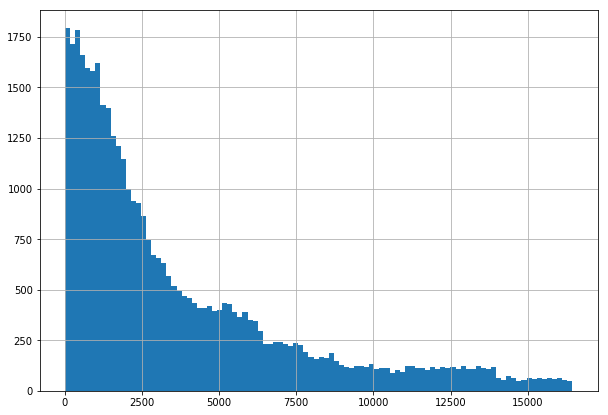

In [51]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

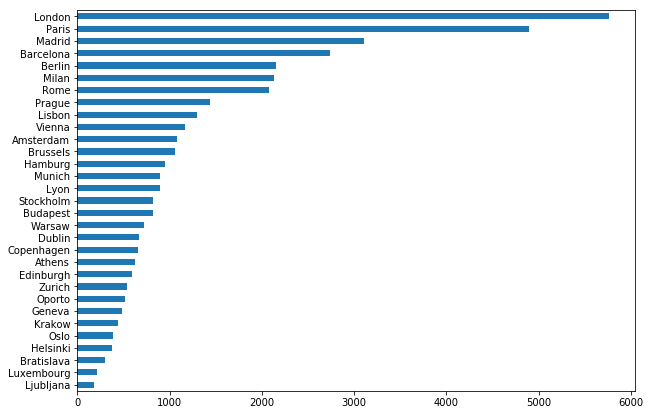

In [52]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

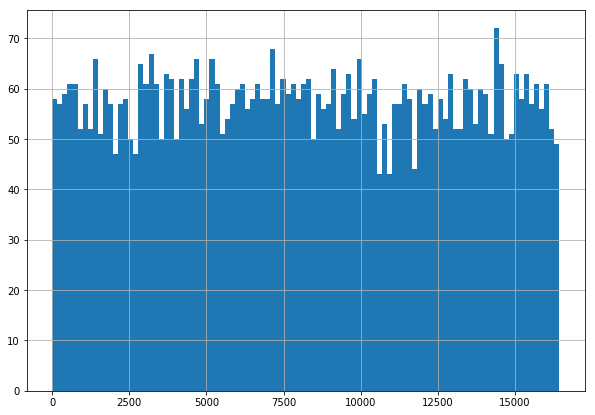

In [53]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

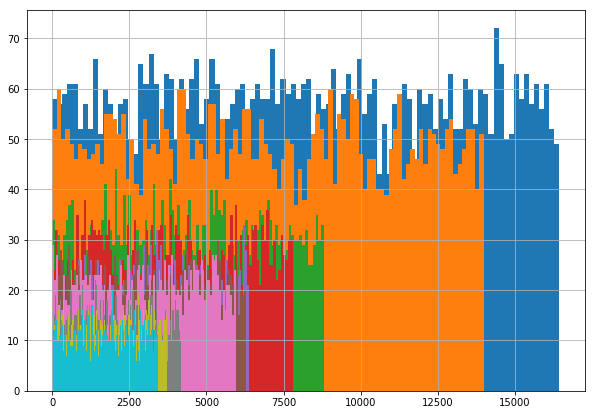

In [54]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

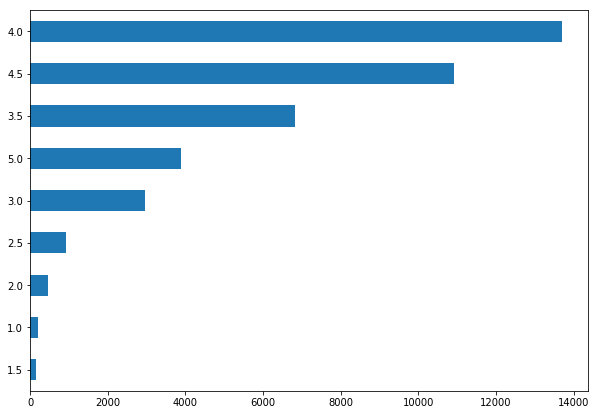

In [55]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

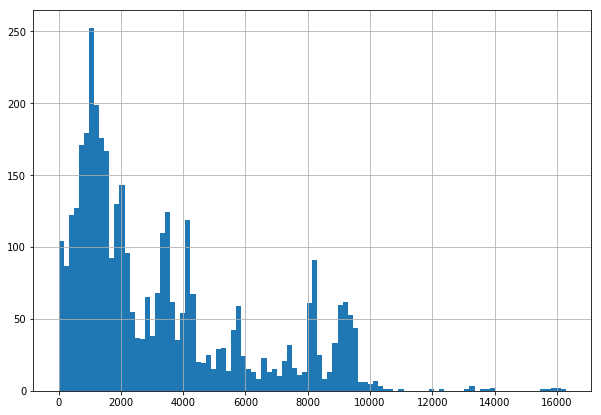

In [56]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

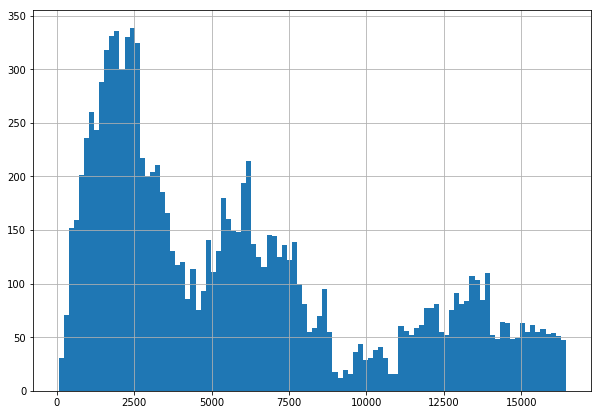

In [57]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

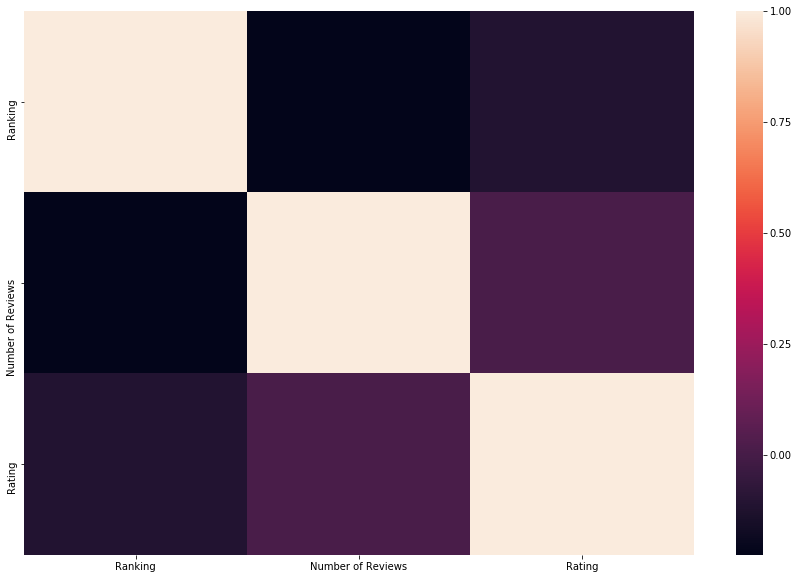

In [58]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

### Adding features

In [37]:
# 1. Is in a capital?
# data['is_capital'] = data['City'].isin(countries_info['capital'].values).astype('uint8')

0        1
1        1
2        0
3        1
4        1
        ..
49995    0
49996    1
49997    1
49998    1
49999    0
Name: City, Length: 50000, dtype: uint8

In [15]:
# 2. Weighed ranking

cities_max_rank = data['City'].value_counts()

for city in cities_max_rank.index:
    cities_max_rank[city] = data[data['City'] == city]['Ranking'].max()


def get_weighed_rank(row):
    city = row['City']
    value = row['Ranking']
    return value / cities_max_rank.loc[city]


# data['Weighed_ranking'] = data.apply(get_weighed_rank, axis=1)

In [70]:
# 3. Gini index

countries_info
cities_info

,Country or Area,Year,Area,Sex,City,City type,Record Type,Reliability,Source Year,Value
0,Austria,2019,Total,Both Sexes,Bregenz,City proper,Estimate - de jure,"Final figure, complete",2019.0,29762.0
1,Austria,2019,Total,Both Sexes,Eisenstadt,City proper,Estimate - de jure,"Final figure, complete",2019.0,14637.0
2,Austria,2019,Total,Both Sexes,Graz,City proper,Estimate - de jure,"Final figure, complete",2019.0,288806.0
3,Austria,2019,Total,Both Sexes,Innsbruck,City proper,Estimate - de jure,"Final figure, complete",2019.0,132110.0
4,Austria,2019,Total,Both Sexes,Klagenfurt,City proper,Estimate - de jure,"Final figure, complete",2019.0,100817.0
...,...,...,...,...,...,...,...,...,...,...
1100,United Kingdom of Great Britain and Northern I...,2011,Total,Female,Reading,City proper,Census - de jure - complete tabulation,"Final figure, complete",2013.0,109469.0
1101,United Kingdom of Great Britain and Northern I...,2011,Total,Female,Sheffield,City proper,Census - de jure - complete tabulation,"Final figure, complete",2013.0,262335.0
1102,United Kingdom of Great Britain and Northern I...,2011,Total,Female,Southampton,City proper,Census - de jure - complete tabulation,"Final figure, complete",2013.0,126021.0
1103,United Kingdom of Great Britain and Northern I...,2011,Total,Female,Stoke-on-Trent,City proper,Census - de jure - complete tabulation,"Final figure, complete",2013.0,136084.0


In [80]:
for city in data['City'].str.lower().unique():
    if city not in cities_info['City'].str.lower().unique():
        print(city)
np.sort(cities_info['City'].unique())

AttributeError: 'numpy.ndarray' object has no attribute 'str'

In [36]:
# 4. Cuisine styles number
data['Cuisine_styles_number'] = data['Cuisine Style'].str.findall('\'(.*?)\'').str.len()

0        2.0
1        5.0
2        1.0
3        5.0
4        6.0
        ... 
49995    4.0
49996    5.0
49997    2.0
49998    5.0
49999    1.0
Name: Cuisine Style, Length: 50000, dtype: float64

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [37]:
# на всякий случай, заново подгружаем данные
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [41]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
#     df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    df_output.drop(['ID_TA'], axis = 1, inplace=True)
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    # тут ваш код по обработке NAN
    print("Filling in NaNs in 'Cuisine Style', 'Price Range', 'Number of Reviews' with parsed data...")
    
    for col in ['Cuisine Style', 'Price Range', 'Number of Reviews']:
#     for col in ['Price Range', 'Number of Reviews']:
        df_output[col] = df_output.apply(fillna_parsed, obj=col, axis=1)
        print(f'{col} finished')
    
    print('\nMarking still missing values...\n')
    df_output['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
    df_output['Price_Range_isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
    
    print('Filling them in...\n')
    df_output['Number of Reviews'].fillna(0, inplace=True)
    df_output['Price Range'].fillna('$$ - $$$', inplace=True)
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    print('Encoding features...\n')
#     df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)
    # тут ваш код не Encoding фитчей
    
#     df_output = cuisine_dummies(df_output)
    
    price_ranges = {np.nan: 0, '$': 1, '$$ - $$$': 2, '$$$$': 3}
    df_output['Price Range'] = df_output['Price Range'].apply(lambda x: price_ranges[x])
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    
    # 1. Is in a capital?
    data['is_capital'] = data['City'].isin(countries_info['capital'].values).astype('uint8')
    
    # 2. Weighed ranking
    data['Weighed_ranking'] = data.apply(get_weighed_rank, axis=1)
    
    # 4. Cuisine styles number
    data['Cuisine_styles_number'] = data['Cuisine Style'].str.findall('\'(.*?)\'').str.len()
    data['Cuisine_styles_number'].fillna(0, inplace=True)
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [42]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

Filling in NaNs in 'Cuisine Style', 'Price Range', 'Number of Reviews' with parsed data...
Cuisine Style finished
Price Range finished
Number of Reviews finished

Marking still missing values...

Filling them in...

Encoding features...



,Ranking,Price Range,Number of Reviews,sample,Rating,is_capital,Weighed_ranking,Cuisine_styles_number,Number_of_Reviews_isNAN,Price_Range_isNAN
5154,4393.0,2,7.0,0,0.0,0,0.700080,NaN,0,0
6902,1017.0,2,0.0,0,0.0,1,0.569110,1.0,1,1
30879,2149.0,2,25.0,1,5.0,1,0.660418,NaN,1,0
47578,5078.0,2,5.0,1,5.0,1,0.853732,1.0,0,0
45741,168.0,2,915.0,1,4.0,1,0.040115,7.0,0,0
2860,5296.0,1,4.0,0,0.0,1,0.831136,1.0,0,0
31817,788.0,2,11.0,1,5.0,1,0.440963,NaN,0,0
3860,7783.0,2,0.0,0,0.0,0,0.998332,1.0,1,0
24989,1493.0,2,36.0,1,4.5,0,0.191508,NaN,0,0
702,3985.0,1,42.0,0,0.0,1,0.242338,4.0,0,0


In [46]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
is_capital                 50000 non-null uint8
Weighed_ranking            50000 non-null float64
Cuisine_styles_number      50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Price_Range_isNAN          50000 non-null uint8
dtypes: float64(5), int64(2), uint8(3)
memory usage: 2.8 MB


In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
